# Google Play Store Apps

Источник данных – датасет Google Play Store Apps (https://www.kaggle.com/lava18/google-play-store-apps). Он содержит 2 таблицы, из них будет использоваться только первая - googleplaystore. Она включает 13 переменных, описывающих приложения в Google Play: 

App – название приложения
Category - категория
Rating – рейтинг приложения
Reviews – число отзывов пользователей
Size – размер приложения
Installs – число установок приложения
Type – платное или бесплатное
Price - цена
Content Rating – возрастной рейтинг (Children / Mature 21+ / Adult)
Genres – жанры (кроме основной категории)
Last Updated – дата последнего обновления
Current Ver – текущая версия приложения
Android Ver – минимальная требуемая версия Android

В магазине Play Store у приложения есть два основных показателя успешности - это количество загрузок и пользовательский рейтинг. Для разработчика, выпускающего приложения, необходимо знать, какие факторы могут оказать влияние на успех его продукта, особенно важны те, на которые он может повлиять.
#### Задача исследования
- Ответить на вопрос: какие приложения становятся популярными? 
- Построить модель, предсказазывающую количество загрузок (Installs)

In [22]:
# Загружаем библиотеки
import numpy as np # работа с векторами
import matplotlib.pyplot as plt # рисовать графики
import seaborn as sns
import pandas as pd # для работы с матрицами
import os as os #для смены директории

# Установим директорию для загрузки данных для модели
os.chdir('C:/Users/Asus/Desktop/magic/data_an/data')

# загружаем данные
df = pd.read_csv('googleplaystore.csv')

Посмотрим на содержимое датасета

In [23]:
df.info() 

df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


## Подготовка данных

Из описания данных видим, что почти все имеют тип objext. Часть из них можно представить в количественном выражении, а часть можно удалить прямо сейчас, чтобы не мешались.

#### Удаляем:

- Type (free/paid) - т.к. можно отслеживать Price.
- Last Updated, Current Ver и Android Ver - показывают актуальность приложения. Удаляем, т.к. наша цель - предсказывать успешность новых приложений, которые изначально являются актуальными (т.к. разработчики стремятся выпускать приложения для самых новых версий Android).
- Genres - содержит 114 категорий, такое число сложно использовать для создания dummy-переменных, а если группировать, то группы будут совпадать с категориями в Category.


In [24]:
df.drop(["Type","Genres","Last Updated","Current Ver","Android Ver",], axis=1, inplace=True)

В Rating и Content Rating есть пропущенные значения.
Удалим пропуски, поскольку датасет и без них достаточно объемный. Также удалим дубликаты.

In [25]:
df.dropna(inplace = True)
df.drop_duplicates(subset='App', inplace=True)

Поработаем с переменными, которые можно привести к числовому типу данных: Reviews, Size, Installs, Price.

Для Reviews можно просто ипользовать приведение типов.

In [26]:
df['Reviews'] = pd.to_numeric(df['Reviews'])

Посмотрим на size:

In [27]:
df['Size'].unique()[0:30]

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M',
       '11M', '24M', 'Varies with device', '9.4M'], dtype=object)

Переведем все размеры в мегабайты, 'Varies with device'  заменим на среднее значение размера в каждой категории.

In [28]:
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

df['Size'].fillna(df.groupby('Category')['Size'].transform('mean'), inplace = True)

В Installs убираем "+" и запятые-разделители, У Price убираем знак $.

In [29]:
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8196 entries, 0 to 10840
Data columns (total 8 columns):
App               8196 non-null object
Category          8196 non-null object
Rating            8196 non-null float64
Reviews           8196 non-null int64
Size              8196 non-null float64
Installs          8196 non-null int64
Price             8196 non-null float64
Content Rating    8196 non-null object
dtypes: float64(3), int64(2), object(3)
memory usage: 576.3+ KB


## Разведочный анализ
Для начала посмотрим характеристики целевой переменной.

##### Installs.
- Минимальное число загрузок в датасете: 1, максимальное: 1 000 000 000.
- Cреднее: 9 165 090, медиана: 100 000.
- Стандартное отклонение: 58 250 870.

Пик распределения приходится на 0, т.е. большая часть приложений в датасете ни разу не скачивалась.

In [30]:
df["Installs"].describe()

count    8.196000e+03
mean     9.165090e+06
std      5.825087e+07
min      1.000000e+00
25%      1.000000e+04
50%      1.000000e+05
75%      1.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

In [31]:
df["Installs"].value_counts()

1000000       1415
100000        1094
10000          987
10000000       937
1000           697
5000000        607
500000         504
50000          457
5000           425
100            303
50000000       202
500            199
100000000      188
10              69
50              56
500000000       24
1000000000      20
5                9
1                3
Name: Installs, dtype: int64

In [32]:
df[df.Installs > 500000000].head()

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
152,Google Play Books,BOOKS_AND_REFERENCE,3.9,1433233,14.166809,1000000000,0.0,Teen
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,11.951723,1000000000,0.0,Everyone
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,11.951723,1000000000,0.0,Everyone
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,11.951723,1000000000,0.0,Everyone
340,Gmail,COMMUNICATION,4.3,4604324,11.951723,1000000000,0.0,Everyone


##### Price


In [33]:
df["Price"].describe()

count    8196.000000
mean        1.037884
std        16.857882
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       400.000000
Name: Price, dtype: float64

В выборке есть приложения, которые стоят 400$. Это довольно большая стоимость для мобильного ПО, посмотрим на них поближе.

In [34]:
df.loc[df.Price > 100]

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
4197,most expensive app (H),FAMILY,4.3,6,1.500,100,399.99,Everyone
4362,💎 I'm rich,LIFESTYLE,3.8,718,26.000,10000,399.99,Everyone
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,10000,400.00,Everyone
5351,I am rich,LIFESTYLE,3.8,3547,1.800,100000,399.99,Everyone
5354,I am Rich Plus,FAMILY,4.0,856,8.700,10000,399.99,Everyone
5355,I am rich VIP,LIFESTYLE,3.8,411,2.600,10000,299.99,Everyone
5356,I Am Rich Premium,FINANCE,4.1,1867,4.700,50000,399.99,Everyone
5357,I am extremely Rich,LIFESTYLE,2.9,41,2.900,1000,379.99,Everyone
5358,I am Rich!,FINANCE,3.8,93,22.000,1000,399.99,Everyone
5359,I am rich(premium),FINANCE,3.5,472,0.965,5000,399.99,Everyone


Все эти приложения очень похожи друг на друга. Для среднего разработчика такие случаи, скорее всего, не интересны, поэтому уберем их и посмотрим на Price снова.

In [36]:
df = df[df.Price < 100]
df["Price"].describe()

#df.loc[df.Price == 0].count() = 7572

count    8181.000000
mean        0.322288
std         1.931291
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        79.990000
Name: Price, dtype: float64

- Минимальная цена: 0, максимальная: 79.99.
- Cреднее: 0.32, медиана: 0.
- Стандартное отклонение: 1.93.

Из 8161 примеров в выборке 7572 приходится на бесплатные приложения, и всего 589 на платные. Бесплатные представлены слишком широко.

In [37]:
free = df.drop(["Price"], axis=1)
paid = df[df.Price > 0]

Построим график распределения загрузок и рейтинга.

Text(0.5,1,'Ratng-Installs ')

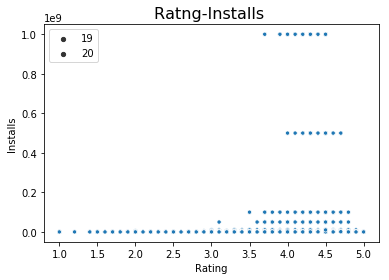

In [38]:
g = sns.scatterplot(y="Installs",x="Rating", data=df, size = 20)
plt.title('Ratng-Installs ',size = 16)

Скачиваемые приложения имеют рейтинг от 3 до 4,9. Наиболее скачиваемые приложения (от 500 млн), имеют рейтинг от 4 до 4,8. Вывод: приложения, которые лучше удовлетворяют потребности пользователей, имеют большее число загрузок.

Далее посмотрим количество приложений в каждой категории.

Text(0.5,1,'')

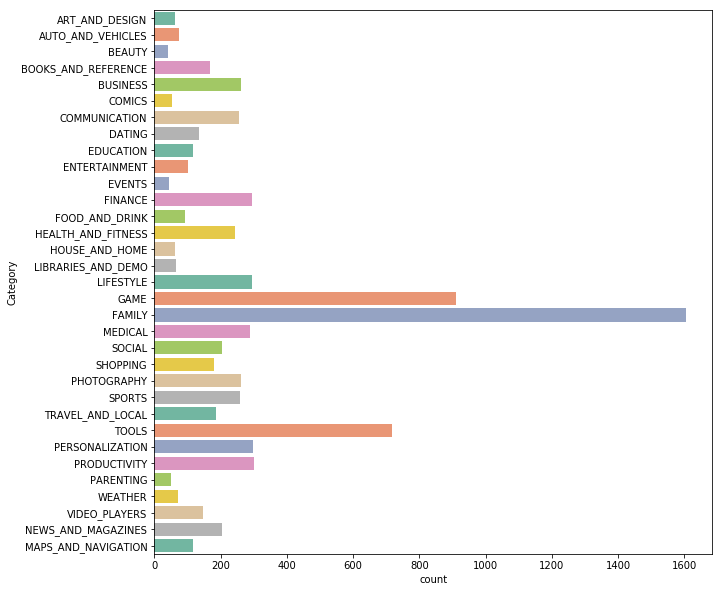

In [39]:
plt.figure(figsize=(10,10))
sns.countplot(y="Category",data=df, palette = "Set2")
plt.title('',size = 16)

На графике ниже мы видим, что наибольшее число приложений имеют категории FAMILY, GAME и TOOLS.

Теперь посмотрим распределение количества установок по категориям. Наиболее скачиваемыми являются приложения для коммуникации и социальные, видео-плееры и развлекательные. За ними идут приложения для продуктивности, для фото и игры.

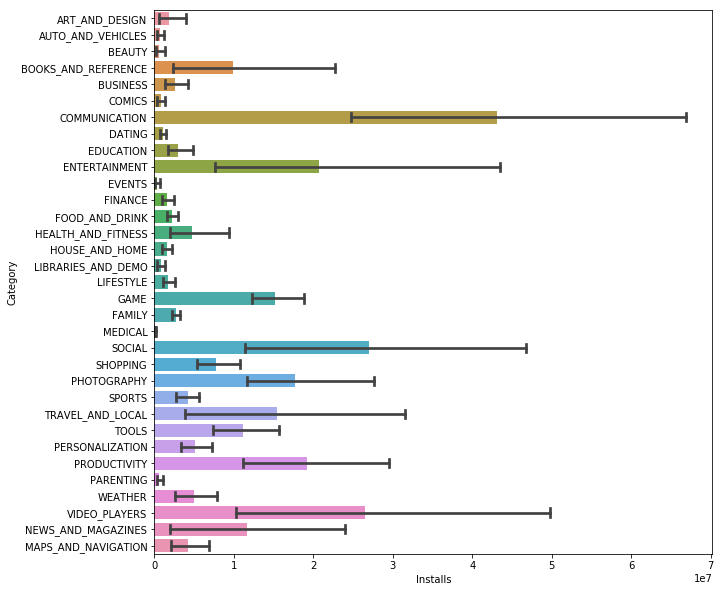

In [40]:
plt.figure(figsize=(10,10))
g = sns.barplot(x="Installs", y="Category", data = df, capsize=.5)

Сопоставив 2 графика, можем увидеть, что приложения для коммуникаций занимают не такую большую долю, но лидируют по скачиваемости. Вывод: скорее всего, есть зависимость от категории.

Далее посмотрим график числа загрузок по цене для платных приложений. 

Text(0.5,1,'Price - Installs (Paid)')

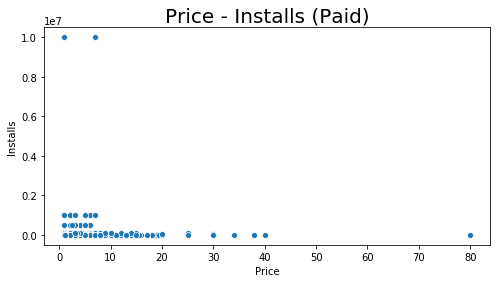

In [41]:
plt.figure(figsize=(8,4))
g = sns.scatterplot(x="Price", y="Installs", data=paid)
plt.title('Price - Installs (Paid)',size = 20)

В основном скачивают приложения стоимостью до 20 долларов. Наибольшей популярностью пользуются приложения стоимостью от 0.99 до 8.

Рассмотрим распределение числа загрузок в зависимости от размера приложения. 

Text(0.5,1,'Size - Installs')

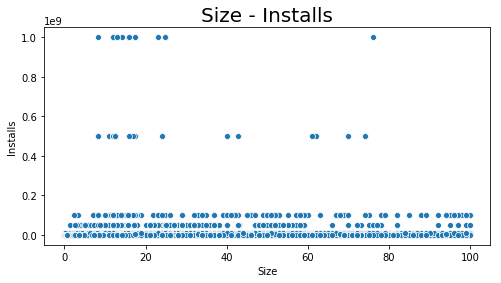

In [42]:
plt.figure(figsize=(8,4))
g = sns.scatterplot(x="Size", y="Installs", data=df)
plt.title('Size - Installs',size = 20)

На основе графика можно предположить, что нет явной зависимости между размером приложения и числом загрузок. 

### Проверка гипотез

Проверим зависимости переменных с помощью коэффициента корреляции Пирсона, результаты в виде корреляционной матрицы.

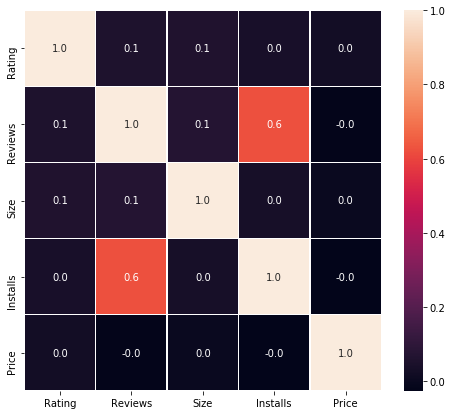

In [43]:
fig,ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(df.corr(), annot=True,linewidths=.5,fmt='.1f')
plt.show()

На ней можем увидеть сильную и довольно очевидную зависимость между числом загрузок (Installs) и отзывов (Reviews) - чем больше людей скачивает, тем больше отзывов.

Для этой матрицы корреляции рассчитывались методом Пирсона. Однако, данные в Installs имеют порядковый характер, в связи с чем имеет смысл использовать коэффициент Спирмена. 

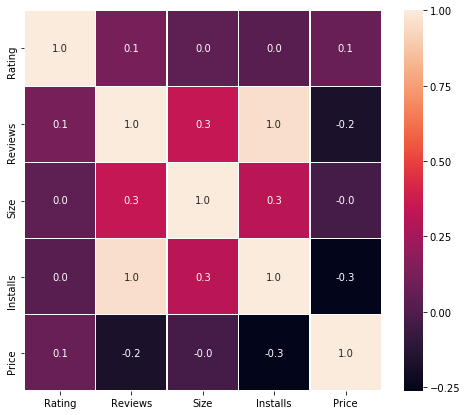

In [44]:
fig,ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(df.corr('spearman'), annot=True,linewidths=.5,fmt='.1f')
plt.show()

Данный метод показал наличие небольшой прямой взаимосвязи между числом загрузок и размером приложения (0,3), и такой же силы обратную взаимосвязь с ценой приложения.

## Построение моделей
Для построения моделей на основе категориальных переменных необходимо создать dummy-переменные.
Прежде чем это делать, сократим число классов значений.
На данный момент в Category - 33 класса, в Content Rating - 6.

Сгруппируем существующие категории в следующие: Games, Productivity, Education, Health_And_Fitness, Hobby, Lifestyle, Social, Entertainment.


In [45]:
df['Category'].replace('HEALTH_AND_FITNESS', 'Health_And_Fitness', inplace = True)
df['Category'].replace('SPORTS', 'Health_And_Fitness', inplace = True)
df['Category'].replace('MEDICAL', 'Health_And_Fitness', inplace = True)

df['Category'].replace('EVENTS', 'Lifestyle', inplace = True)
df['Category'].replace('FOOD_AND_DRINK', 'Lifestyle', inplace = True)
df['Category'].replace('LIFESTYLE', 'Lifestyle', inplace = True)
df['Category'].replace('SHOPPING', 'Lifestyle', inplace = True)
df['Category'].replace('PARENTING', 'Lifestyle', inplace = True)

df['Category'].replace('PERSONALIZATION', 'Productivity', inplace = True)
df['Category'].replace('TOOLS', 'Productivity', inplace = True)
df['Category'].replace('PRODUCTIVITY', 'Productivity', inplace = True)
df['Category'].replace('WEATHER', 'Productivity', inplace = True)
df['Category'].replace('MAPS_AND_NAVIGATION', 'Productivity', inplace = True)

df['Category'].replace('GAME', 'Games', inplace = True)
df['Category'].replace('FAMILY', 'Games', inplace = True)

df['Category'].replace('COMICS', 'Entertainment', inplace = True)
df['Category'].replace('ENTERTAINMENT', 'Entertainment', inplace = True)
df['Category'].replace('LIBRARIES_AND_DEMO', 'Entertainment', inplace = True)
df['Category'].replace('VIDEO_PLAYERS', 'Entertainment', inplace = True)
df['Category'].replace('NEWS_AND_MAGAZINES', 'Entertainment', inplace = True)

df['Category'].replace('COMMUNICATION', 'Social', inplace = True)
df['Category'].replace('DATING', 'Social', inplace = True)
df['Category'].replace('SOCIAL', 'Social', inplace = True)

df['Category'].replace('BOOKS_AND_REFERENCE', 'Education', inplace = True)
df['Category'].replace('EDUCATION', 'Education', inplace = True)
df['Category'].replace('BUSINESS', 'Education', inplace = True)
df['Category'].replace('FINANCE', 'Education', inplace = True)

df['Category'].replace('ART_AND_DESIGN', 'Hobby', inplace = True)
df['Category'].replace('AUTO_AND_VEHICLES', 'Hobby', inplace = True)
df['Category'].replace('BEAUTY', 'Hobby', inplace = True)
df['Category'].replace('HOUSE_AND_HOME', 'Hobby', inplace = True)
df['Category'].replace('PHOTOGRAPHY', 'Hobby', inplace = True)
df['Category'].replace('TRAVEL_AND_LOCAL', 'Hobby', inplace = True)
df['Category'].value_counts()

Games                 2516
Productivity          1507
Education              846
Health_And_Fitness     794
Hobby                  688
Lifestyle              665
Social                 593
Entertainment          572
Name: Category, dtype: int64

В Content Rating заменим Unrated на Everyone, Adults only 18+  на Mature 17+.

In [46]:
df['Content Rating'].replace('Adults only 18+', 'Mature 17+', inplace = True)
df['Content Rating'].replace('Unrated', 'Everyone', inplace = True)

Теперь создаем dummy-переменные.

In [47]:
data = pd.get_dummies(df, columns= ["Category", "Content Rating"])
data.drop(["App","Reviews"], axis=1, inplace=True)
data = data.astype(float, casting='safe')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8181 entries, 0 to 10840
Data columns (total 16 columns):
Rating                         8181 non-null float64
Size                           8181 non-null float64
Installs                       8181 non-null float64
Price                          8181 non-null float64
Category_Education             8181 non-null float64
Category_Entertainment         8181 non-null float64
Category_Games                 8181 non-null float64
Category_Health_And_Fitness    8181 non-null float64
Category_Hobby                 8181 non-null float64
Category_Lifestyle             8181 non-null float64
Category_Productivity          8181 non-null float64
Category_Social                8181 non-null float64
Content Rating_Everyone        8181 non-null float64
Content Rating_Everyone 10+    8181 non-null float64
Content Rating_Mature 17+      8181 non-null float64
Content Rating_Teen            8181 non-null float64
dtypes: float64(16)
memory usage: 1.4 MB


In [48]:
# импорты
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score

In [49]:
data1 = data.drop(["Installs"], axis=1)
X = data1.iloc[:,0:15].values 
y = data.iloc[:,2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [50]:
# дерево
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print(dtree.score(X_train, y_train), dtree.score(X_test, y_test))

0.8528422982885085 0.15271838729383017


Очевидно, что имеет место переобучение - дерево потеряло способность к обобщению.
Попробуем ограничить число листовых вершин.

In [51]:
dtree = DecisionTreeClassifier(max_leaf_nodes = 40)
dtree.fit(X_train, y_train)
print(dtree.score(X_train, y_train), dtree.score(X_test, y_test))

0.25488997555012227 0.21624923640806354


Эксперименты с количеством "листов" показали, что оптимальное соотношение между результатами на обучающей и на тестовой выборках достигаются при 40 крайних вершинах. Однако, модель все еще плохая.

Попробуем построить регрессию (данные разбиты по порядкам, поэтому логистическая справляется лучше линейной).

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# логистическая регрессия
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train), logreg.score(X_test, y_test))

results = cross_val_score(logreg, X_train, y_train, cv=3)
# результаты кросс-валидации
results.mean()

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.21286674816625917 0.20158827122785583


c:\python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to

0.20705514035849149

Эксперименты с другими видами моделей не дали улучшения результата (0.20 у регрессии, 0,22 у градиентного бустинга), из чего можно сделать вывод, что на основе исходных данных нельзя сделать однозначный вывод об успешности приложения. Об этом говорит и практика - успех игр или других приложений зависит от дизайна, удобства использования, маркетинга и многих других факторов. 